In [132]:
import numpy as np
import pandas as pd
import subprocess
import time
import holidays

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rcParams 
from tqdm import tqdm
from datetime import datetime, date
from IPython.display import IFrame
import seaborn as sns

import statsmodels.api as sm

#========================   PATHS   ========================#
TRAIN_PATH= 'data/train.csv'
TEST_PATH= 'data/test.csv'
MASK_PATH= 'https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png'
CNG_PATH= 'img/congestion_table.png' #congestion table
SAF_PATH= 'img/seasonalAdjFac.png' #seasonality adjustment factor

# Load Datasets
#### Train Dataset
    The train dataset contains over 55,423,856 rows and 7 columns, making it hard to manipulate. The following solution parts the dataset into chunks that are afterwards concatenated. Also, it includes a faster way to read date type values, than the pre-defined parse_date parameter of read_csv.
Source: [kaggle](https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows)

In [101]:
%%time

df_list = [] # list to hold the batch dataframe
chunksize = 5_000_000 # 5m rows chunks

# Columns to keep and input for dtype
traintypes = {'fare_amount': np.float32,
              'pickup_datetime': str, 
              'pickup_longitude': np.float32,
              'pickup_latitude': np.float32,
              'dropoff_longitude': np.float32,
              'dropoff_latitude': np.float32,
              'passenger_count': int}


for df_chunk in tqdm(pd.read_csv(TRAIN_PATH,
                                 nrows= 5_000_000,
                                 usecols= list(traintypes.keys()),
                                 dtype= traintypes,
                                 chunksize= chunksize)):
     
    # Faster than using parse_dates
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str[0: 13]
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'],
                                                 utc=True, 
                                                 format='%Y/%m/%d %H')
    df_list.append(df_chunk) 

        
# Merge all dataframes into one dataframe
train = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list



1it [00:11, 11.73s/it]

CPU times: user 11.1 s, sys: 1.18 s, total: 12.3 s
Wall time: 11.9 s


In [ ]:
train.head()

#### Load Test Datset

In [104]:
test = pd.read_csv(TEST_PATH, usecols=[1,2,3,4,5,6], header= 0)
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


## Data Cleaning
#### Remove duplicates

In [105]:
print(f"From {train.shape[0]} rows,")
train.drop_duplicates(inplace=True)
print(f"to {train.shape[0]} rows")

From 5000000 rows,
to 4998527 rows


#### Remove Null values

In [106]:
#check for missing values
print(f"Missing values in TRAIN datset: \n{train.isnull().sum().sort_values(ascending=False)}\n")
print(f"Missing values in TEST datset: \n{test.isnull().sum().sort_values(ascending=False)}\n")

#drop the missing values
indexes = list(train.loc[train.isnull().any(1)].index)
train.drop(index= indexes, inplace= True)

Missing values in TRAIN datset: 
dropoff_latitude     36
dropoff_longitude    36
passenger_count       0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
fare_amount           0
dtype: int64

Missing values in TEST datset: 
passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
dtype: int64



#### Variable Fares 
    There are fares with negative or zero values. The corresponding rows are removed.

In [107]:
# Description
print(train['fare_amount'].describe())

bad_values= train.loc[train['fare_amount']<=0].index
print(f"\nRows with negative/ zero values: {len(bad_values)}")

# Remove rows
train.drop(bad_values, axis=0, inplace=True)

count    4.998491e+06
mean     1.134178e+01
std      9.820927e+00
min     -1.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

Rows with negative/ zero values: 343


#### Variable Passengers 
    On the train dataset, there are rides with zero or negative passengers. Also, there are rides with an excessive amount of passengers. The corresponding rows are removed.

In [108]:
print("Passengers in the test dataset:", test['passenger_count'].describe())
print("\nPassengers in the train dataset:", train['passenger_count'].describe())

# Position of rows
bad_values= list(train.loc[train['passenger_count']>12].index) + \
            list(train.loc[train['passenger_count']<=0].index)

# Deletion
train.drop(index= bad_values, inplace=True)

Passengers in the test dataset: count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

Passengers in the train dataset: count    4.998148e+06
mean     1.684875e+00
std      1.331980e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64


#### Date Variable

In [109]:
print(f"Earliest date: {train['pickup_datetime'].min()}")
print(f"Latest date: {train['pickup_datetime'].max()}")
print(f"Time Span: {train['pickup_datetime'].max() -train['pickup_datetime'].min()}")

Earliest date: 2009-01-01 00:00:00+00:00
Latest date: 2015-06-30 23:00:00+00:00
Time Span: 2371 days 23:00:00


#### Spatial Variables
   Initially, the bounds of the NYC are set, as they were drawn on the map of [boundingbox](https://boundingbox.klokantech.com/). Then, the dataset is filtered. 

In [110]:
# Boundaries of the metropolitan area
Boundaries = (-74.3, -73.6, 40.5, 41)
long_lim = list(Boundaries[0:2])
lat_lim = list(Boundaries[2:4])


# NYC Coordinates
nyc = (40.7141667, -74.0063889)
# Airports Coordinates
jfk= (40.6441666667, -73.7822222222)
lgd= (40.7769271, -73.87396590000003)



# Remove rides outside the metropolitan area
# Longitude
train = train[(train.pickup_longitude> long_lim[0]) & (train.pickup_longitude < long_lim[1])]
train = train[(train.dropoff_longitude> long_lim[0]) & (train.dropoff_longitude < long_lim[1])]
# Latitude
train = train[(train.pickup_latitude> lat_lim[0]) & (train.pickup_latitude < lat_lim[1])]
train = train[(train.dropoff_latitude> lat_lim[0]) & (train.dropoff_latitude < lat_lim[1])]

#### Mask datapoints in the water
    A number of points are located on coordinates that correspond to sea or rivers. These datapoints are detected, with a mask from a map of the area, and are deleted. Initially, the mask is transformed in order to only contain 0 and 1 values. Then, the coordinates are transformed to the local X~Y system and the mask is applied to eliminate fault datapoints.

In [111]:
# Load mask
mask = plt.imread(MASK_PATH)[:,:,0] #y first, x second

# Need to make it boolean in order to use it as mask
print("Unique values before:\n\n",np.unique(mask))

mask = mask>0.5
print("\nUnique values after:\n\n",np.unique(mask))

Unique values before:

 [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.02745098
 0.03529412 0.05490196 0.05882353 0.06666667 0.07450981 0.08235294
 0.08627451 0.09019608 0.09803922 0.12156863 0.12941177 0.14509805
 0.14901961 0.16470589 0.16862746 0.22745098 0.23921569 0.26666668
 0.27058825 0.32941177 0.33333334 0.34117648 0.37254903 0.3882353
 0.4117647  0.41568628 0.48235294 0.52156866 0.54509807 0.58431375
 0.59607846 0.627451   0.6666667  0.68235296 0.70980394 0.7137255
 0.72156864 0.73333335 0.7411765  0.7764706  0.7882353  0.8235294
 0.827451   0.85490197 0.8627451  0.88235295 0.8862745  0.9019608
 0.92156863 0.92941177 0.9411765  0.9529412  0.9607843  0.9764706
 0.98039216 1.        ]

Unique values after:

 [False  True]


In [112]:
def to_XY (longitude, latitude, mask, Boundaries):
    minLongitude = Boundaries[0]
    minLatitude = Boundaries[2]
    
    length = Boundaries[1] - minLongitude
    width = Boundaries[3] - minLatitude
    
    mask_length = mask.shape[1]
    mask_width = mask.shape[0]
    
    x = mask_length * (longitude - minLongitude) / length
    y = mask_width * (1 - (latitude - minLatitude) / width ) #imread reads from +y to -y

    
    return x.astype("int") ,y.astype("int")

#===================================================================================

# Application

pickupX, pickupY = to_XY(longitude= train.pickup_longitude, 
                         latitude= train.pickup_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

dropoffX, dropoffY = to_XY(longitude= train.dropoff_longitude, 
                         latitude= train.dropoff_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

# Multiply X,Ys with the mask
# Bitwise addition to concatenate all points into one array
idx = mask[pickupY, pickupX] & mask[dropoffY, dropoffX]
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 52075


In [113]:
print(f"From {train.shape[0]} rows,")

# Keep only points in land
train = train[idx]

print(f"to {train.shape[0]} rows.")

From 4872759 rows,
to 4820684 rows.


# New Features

## Within Manhattan Column

In [ ]:
# Source: https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python 

import matplotlib.path as mpltPath
manhattan_path = mpltPath.Path([[40.698,-74.019 ],[40.757,-74.014 ],
                                [ 40.881745, -73.934875 ],[ 40.872186, -73.909654 ],
                                [40.834051, -73.934120],[ 40.809238, -73.933307 ],
                                [40.798337, -73.927591],[ 40.773668, -73.941674 ],
                                [40.741346, -73.966607],[40.707832, -73.974694]])


def is_within(lon,lat,path):  #(Latitude, Longitude, Boundaries)
    return path.contains_point([lon,lat])

train['manhattan'] = np.vectorize(is_within)(temp['pickup_latitude'], #transform function to being numpy-aware
                                                      temp['pickup_longitude'],
                                                      manhattan_path) & \
                    np.vectorize(is_within)(temp['dropoff_latitude'],
                                                      temp['dropoff_longitude'],
                                                      manhattan_path)

# Percentage of rides copletely within Manhattan
print ('{:.3}% of the sample rides are wholly within Manhattan'\
       .format(train[train.manhattan].shape[0] / train.shape[0] * 100))

## Distance to Airport Coordinates

Another important factor in price is whether the ride was called from an airport or not. Airport pickups and dropoffs have a fixed price, which can affect greatly the fare price. We want to make sure that these rides are treated separately from regular rides.

In [115]:
# Airport Coordinates

jfk_coordinates = (40.639722, -73.778889) # JFK: John F. Kennedy International Airport
ewr_coordinates = (40.6925, -74.168611)  # EWR: Newark Liberty International Airport
lga_coordinates = (40.77725, -73.872611) # LGA: LaGuardia Airport

def get_haversine_dist(start_lat, start_lon, finish_lat, finish_lon):

    r = 3956 # radius of earth in miles
    # convert latitude/longitude degrees to radians
    start_lat, start_lon, finish_lat, finish_lon = map(np.radians,
                                                             [start_lat, start_lon, 
                                                              finish_lat, finish_lon])
    #Compute distances along lat, lon dimensions
    dlat = finish_lat - start_lat
    dlon = finish_lon - start_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(start_lat) * np.cos(finish_lat) * np.sin(dlon/2.0)**2
    
    return 2 * r * np.arcsin(np.sqrt(a))

# Add distance distance calculations to the training dataset

train['distance_of_ride'] = get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], 
                                   train['dropoff_latitude'] , train['dropoff_longitude'])
train['distance_pickup_jfk'] =  get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], jfk_coordinates[0], jfk_coordinates[1]) 
train['distance_dropoff_jfk'] =  get_haversine_dist(train['dropoff_latitude'], train['dropoff_longitude'], jfk_coordinates[0], jfk_coordinates[1]) 

train['distance_pickup_ewr'] =  get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], ewr_coordinates[0], ewr_coordinates[1]) 
train['distance_dropoff_ewr'] =  get_haversine_dist(train['dropoff_latitude'], train['dropoff_longitude'], ewr_coordinates[0], ewr_coordinates[1]) 

train['distance_pickup_lga'] =  get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], lga_coordinates[0], lga_coordinates[1]) 
train['distance_dropoff_lga'] =  get_haversine_dist(train['dropoff_latitude'], train['dropoff_longitude'], lga_coordinates[0], lga_coordinates[1])


## Airport Ride Boolean

In [243]:
# Columns that 
train['airport_ride_type'] = None
train.loc[(train['distance_pickup_jfk'] < 1.5) | (train['distance_dropoff_jfk'] < 1.5), 'airport_ride_type']= 'JFK'
train.loc[(train['distance_pickup_ewr'] < 1.5) | (train['distance_dropoff_ewr'] < 1.5), 'airport_ride_type']= 'EWR'
train.loc[(train['distance_pickup_lga'] < 1.5) | (train['distance_dropoff_lga'] < 1.5), 'airport_ride_type']= 'LGA'

In [267]:
summary = train.groupby(['airport_ride_type']).agg({'fare_amount': len}).rename(columns={'fare_amount': 'count_of_rows'})

In [274]:
print('The number of rides that were dropped off from: ')
print('JFK: {num}'.format(num= summary.loc['JFK','count_of_rows']))
print('EWR: {num}'.format(num=summary.loc['EWR','count_of_rows']))
print('NGA: {num}'.format(num=summary.loc['LGA','count_of_rows']))

The number of rides that were dropped off from: 
JFK: 91771.0
EWR: 6511.0
NGA: 158117.0


#### Clean Data based on distance
        It appears that for many rows, the pickup point is the same as the dropoff point, while there is a fare charged and a number of passengers. We assume it corresponds to rides charging the waiting time for the taxi without an actual route. Therefore, the subset is extracted from the original dataset and retained.

In [116]:
wait = train.loc[train.distance_of_ride==0]
train = train.loc[train.distance_of_ride!=0]

## Congestion Column
In order to incorporate external information on traffic patterns, we created a new column containing a traffic congestion factor for every given datetime. It takes into consideration daily fluctuation of traffic congestion, as well as seasonal and year fluctuation.
Sources:
         [Traffic Congestion Statistics](https://www.tomtom.com/en_gb/trafficindex/city/new-york) \
         [Seasonal Adjustment Factors](https://www.dot.ny.gov/divisions/engineering/technical-services/hds-respository/Tab/NYSDOT_2017_Seasonal_Adjustment_Factors.pdf)

In [117]:
# Get National Holidays
all_hols = []
for year in range(2008, 2019):
    for date, name in sorted(holidays.US(state='NY', years=year).items()):
        all_hols.append(date)

# Seasonality
# Jan=0,...Dec=11
urban = [0.879,0.905,0.966,1.016,1.052,1.069,1.047,1.054,1.039,1.033,0.976,0.964]
suburban = [0.782,0.804,0.868,0.948,1.076,1.132,1.230,1.224,1.097,1.035,0.927,0.876]
# Yearly
cong_yearly = {2009: 1.25, 2010: 1.26, 2011: 1.25, 2012: 1.22, 2013: 1.25, 2014: 1.31, 2015: 1.34, 2016: 1.38}
# Weekdays
# Monday=0,...Sunday=6
cong_morning = {0: 1.47, 1: 1.52, 2: 1.49, 3: 1.50, 4: 1.43}
cong_evening = {0: 1.53, 1: 1.59, 2: 1.61, 3: 1.63, 4: 1.65}

# Highway - Non-Highway ratio
H_ratio = 3_435 / 98_091
nH_ratio = 1 - H_ratio

def calc_congestion(pickup_date: datetime.timestamp, holiday_dates: list) -> float:        
    
    '''
    To use the seasonality table, we need to estimate the factor group. This is done with the information
    from the congestion table. The ratio of highways to no-highways is used as an indication of the urban
    and suburban factors for the dataset. 
    
    We derive separate factors from each part of the tables. The overall factor is then calculated as the
    product of those individual factors.
    
    1. Seasonal Adjustment Factor.
        
        Seasonality:
        H_ratio * suburban + nH_ratio * urban
    
    2. Traffic Congestion Statistics.
    
        Congestion Level:
        cong_yearly
    
        Morning Peak       #Mon-Fri (5:00 to 10:00):
        cong_morning
    
        Evening Peak       #Mon_Fri (16:00 to 20:00):
        cong_evening
    
    The congestion is given as an overall percentage to be associated with each pickup_datetime.
    '''

    year = pickup_date.year
    month = pickup_date.month - 1
    weekday = pickup_date.weekday()
    date = pickup_date.date()
    hour = pickup_date.hour

    # The seasonal factor is derived as a ratio between urban and suburban
    seasonal_factor = H_ratio * urban[month] + nH_ratio * suburban[month]

    # The year factor is assigned staright from the year dictionary
    if year in cong_yearly:
        year_factor = cong_yearly[year]
    
    day_factor = 1.
    # The daily factor checks for being a workday and not a holiday. Then the rush hour is checked 
    if weekday in range(5) and date not in all_hols:        
        if hour>=5 and hour<=10: #morning peak
            day_factor = cong_morning[weekday]
        elif hour>=16 and hour<=20: #evening peak
            day_factor = cong_evening[weekday]
        
            
    return year_factor * seasonal_factor * day_factor



# Create the new column
train = train.assign( congestion= train.pickup_datetime.apply(lambda x: calc_congestion(x, all_hols)))

## Pickup Date Breakdown

TEXT

In [118]:
# TODO : does this go here or in the new column area 
# Breakdown of pick up datetime to its time components 

train['hour'] = train.pickup_datetime.dt.hour
train['month'] = train.pickup_datetime.dt.month
train['year'] = train.pickup_datetime.dt.year
train['weekday'] = train.pickup_datetime.dt.weekday

# Fare per mile 
train['fare_per_mile'] = train.fare_amount / train.distance_of_ride
train.loc[train['fare_per_mile'] == np.inf,'fare_per_mile'] = 0

# Exploratory Data Analysis

## Summarize Variables

Below we created a chart with various summary statistics about each column. This allows us to get a quick sense of the kind of data. 

In [166]:
# TODO: change color of the chart

import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization

summary = train.describe().transpose().reset_index().rename(columns = {"index" : 
                                                                          "variable"})
summary  = np.around(summary,2)

var_lst = [summary["variable"],summary["count"],summary['mean'],summary['std'],
           summary["min"],summary["25%"],summary["50%"],summary["75%"],summary["max"]]

table = go.Table(header = dict(values = summary.columns.tolist(),
                               line = dict(color = ['#506784']),
                               fill = dict(color = ['#119DFF']),
                              ),
                 cells  = dict(values = var_lst,
                               line = dict(color = ['#506784']),
                               fill = dict(color = ["lightgrey",'#F5F8FF']),
                              ),
                 columnwidth = [130,80,80,80,80,80,80,80,80])
                
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[table],layout=layout)
py.iplot(figure)

## Visualise datapoints
W sample from the dataset the spatial points are ploted. The magnitude of the points is sufficient to view an abstract mapping of the metropolitan area. Also, it is interesting to see that the vast majority of the geospatial points are located in Manhattan

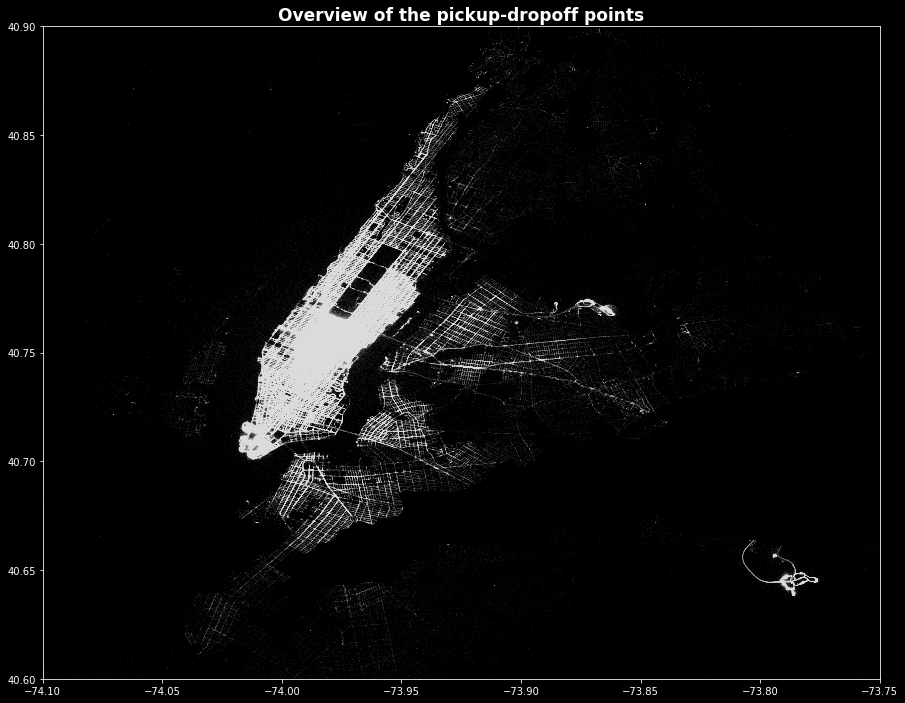

CPU times: user 7.3 s, sys: 751 ms, total: 8.05 s
Wall time: 8.52 s


In [114]:
%%time
%matplotlib inline

# Plot pickups, dropoffs
plot_df= train

a1 = list(plot_df.pickup_longitude)
a2 = list(plot_df.pickup_latitude)

b1 = list(plot_df.dropoff_longitude)
b2 = list(plot_df.dropoff_latitude)

# Plot 

plt.style.use('dark_background')
plt.figure(figsize = (15,12))

plt.plot( a1, a2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.plot( b1, b2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.title(label= "Overview of the pickup-dropoff points", fontdict= {'weight' : 'bold', 'size'   : 17})

plt.xlim((-74.1, -73.75))
plt.ylim((40.6, 40.9))
plt.show()

## Relationships between Variables

#### All Histograms

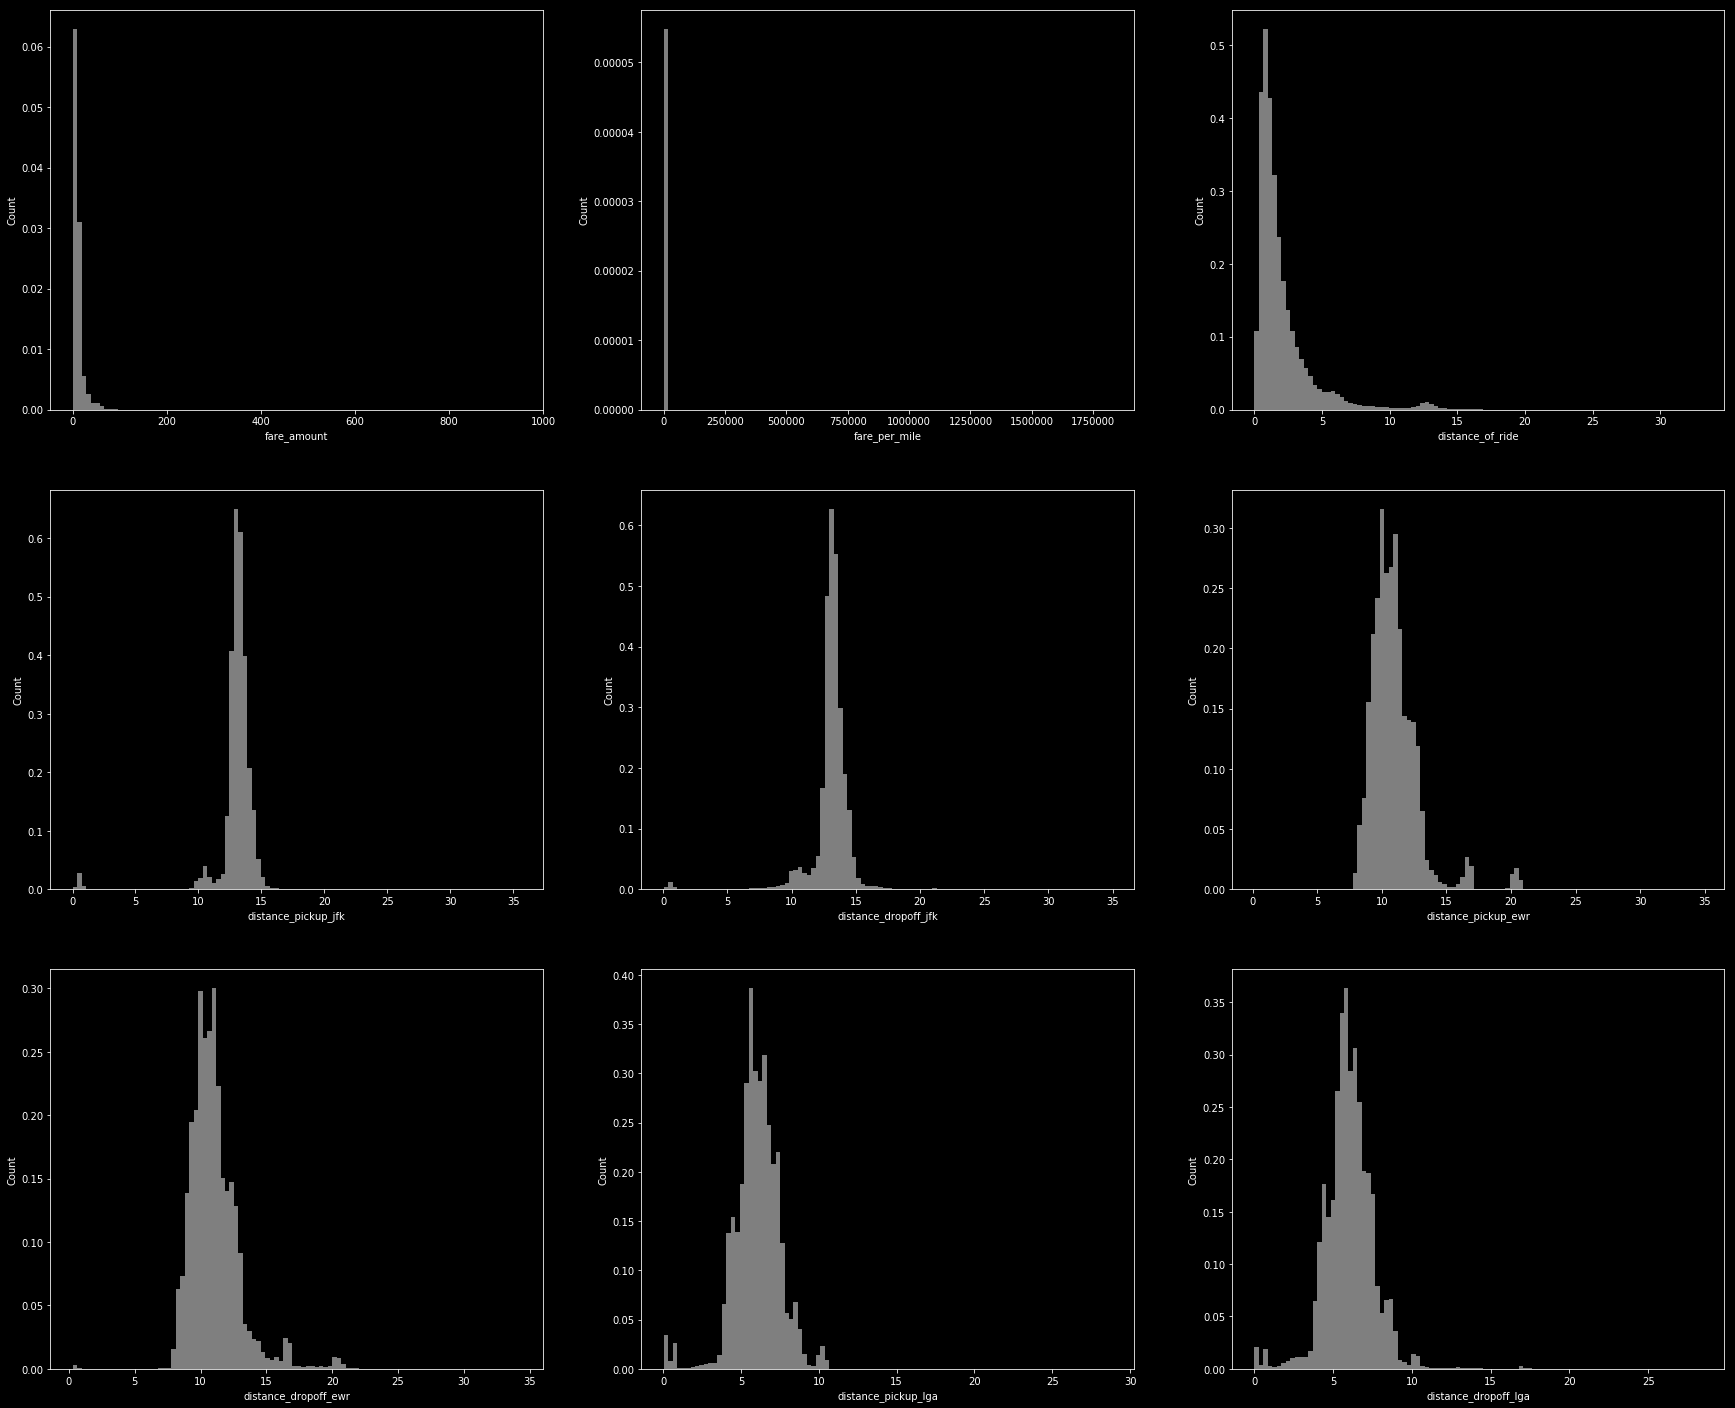

In [119]:
#### Histograms for Distance Attributes

# TODO: Decide if we want to keep all or just some of these histograms

# Generically define how many plots along and across
cols_to_plot = [
    'fare_amount',
    'fare_per_mile',
    'distance_of_ride',
    'distance_pickup_jfk',
    'distance_dropoff_jfk',
    'distance_pickup_ewr',
    'distance_dropoff_ewr',
    'distance_pickup_lga',
    'distance_dropoff_lga']

train_view = train[cols_to_plot]
ncols = 3
nrows = int(np.ceil(len(train_view.columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 25))

counter = 0
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]

        # Plot when we have data
        if counter < len(train_view.columns):
            values = train[train_view.columns[counter]]
#             weights = np.ones_like(values)/float(len(values))
            plt.hist(myarray, weights=weights)
            ax.hist(values, weights=weights, bins=100, density =True ,color='white', alpha=0.5, label='{}'.format(train_view.columns[counter]))
            ax.set_xlabel(train_view.columns[counter])
            ax.set_ylabel('Count')
#           ax.set_ylim([0, 5])
#           leg = ax.legend(loc='upper left')

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()
        counter += 1

plt.show()

#### Fare per Mile

Text(0.5, 1.0, 'Fare/Mile per Hour of the day')

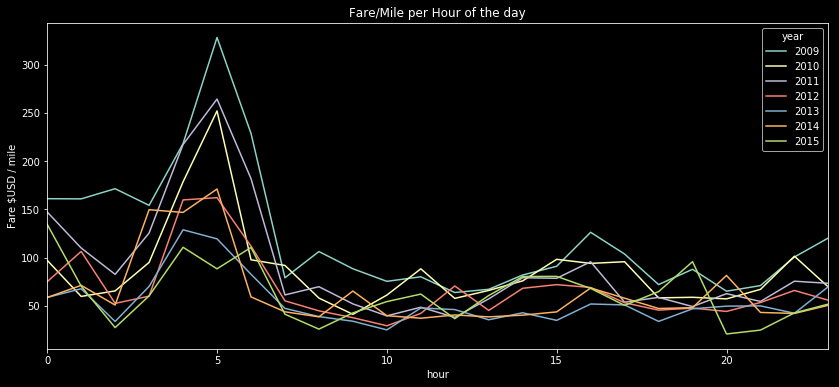

In [21]:
train.pivot_table('fare_per_mile', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile')
plt.title('Fare/Mile per Hour of the day')

From the plot of fare by hour, we see that the most expensive taxi rides are at 5 AM  


TODO: INSERT MORE TEXT

Text(0.5, 1.0, 'Fare/Mile per Weekday')

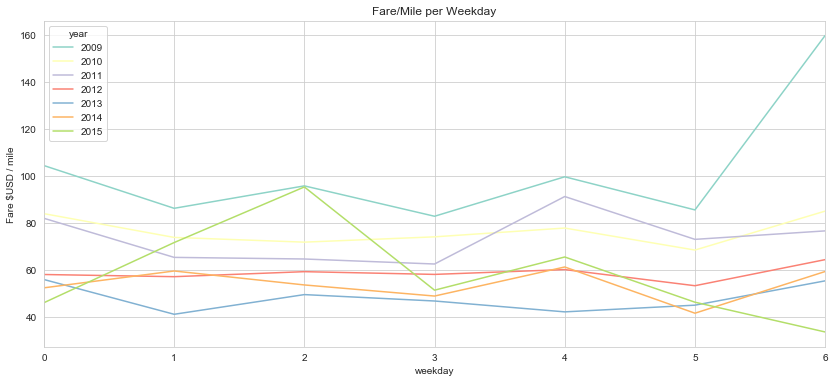

In [278]:
train.pivot_table('fare_per_mile', index='weekday', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare $USD / mile')
plt.title('Fare/Mile per Weekday')

In [ ]:
TODO: COMMENT ON GRAPH ABOVE

#### Relationship between distance and fare

/Users/miraekim/miniconda3/envs/main_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



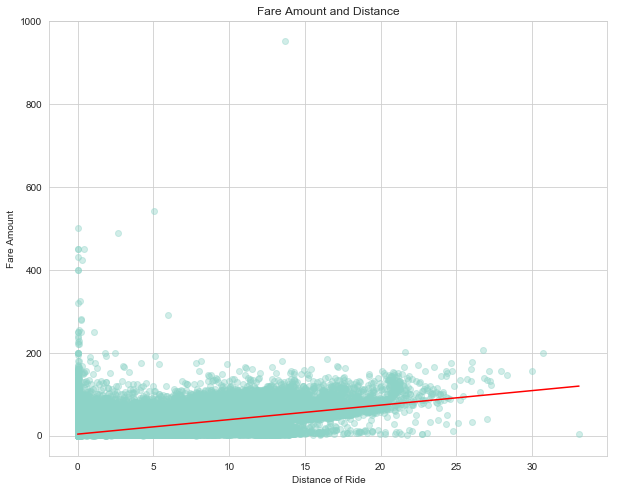

In [209]:
# Simple linear regression predicting fare_amount with respect to distance
dist_x = train['distance_of_ride']
y = train['fare_amount']
results = sm.OLS(y,sm.add_constant(dist_x)).fit()
X_plot = np.linspace(0,max(dist_x),100)

plt.figure(figsize = (10,8))
plt.plot(X_plot, X_plot*results.params[0] + results.params[1], color = 'red')
plt.scatter(train.distance_of_ride, train.fare_amount, alpha=0.4)
plt.xlabel('Distance of Ride')
plt.ylabel('Fare Amount')
plt.title('Fare Amount and Distance')
plt.show()
# axs[0].set_title('All data')

[Text(0, 0.5, 'Fare Amount'), Text(0.5, 0, 'Airport Ride Type')]

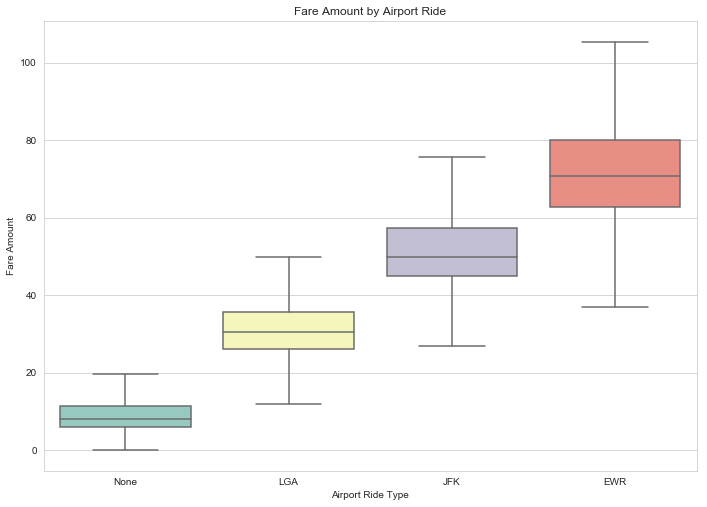

In [287]:
#need to label NA values in airport type as none to be able to display in the bar graph
train.loc[train['airport_ride_type'].isna(),'airport_ride_type'] = 'None'

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
ax = sns.boxplot(data=train, x='airport_ride_type',y='fare_amount', showfliers=False)
ax.set_title('Fare Amount by Airport Ride')
ax.set(ylabel='Fare Amount', xlabel='Airport Ride Type')

In [ ]:
#### Dropoff Date Distribution

## XG Boost

We will first use Extreme Gradient Boosting to try to predict taxi fares. XGBoost is a supervised learning algorithm that uses the features x_i of our data to predict a target variable y_i.

In [23]:
# TODO: move this to the top later
import xgboost as xgb
from sklearn.model_selection import train_test_split

#### Prepare training and testing set

In [32]:
train_head = train.head(1000) # TODO: delete 
train_head_x = train_head.drop(['pickup_datetime', 'fare_amount'],1) #pickup_datetime is datetime object which is not accepted by XG Boost 
train_head_y = train_head['fare_amount']

x_train,x_test,y_train,y_test = train_test_split(train_head_x, train_head_y ,random_state=0,test_size=0.10)

# create DMatrix for XG boosting purposes
dtrain = xgb.DMatrix(train_head_x, train_head_y)

In [120]:
x_train

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_of_ride,distance_pickup_jfk,distance_dropoff_jfk,distance_pickup_ewr,distance_dropoff_ewr,distance_pickup_lga,distance_dropoff_lga,congestion,hour,month,year,weekday,fare_per_mile
825,-73.991737,40.744404,-73.959885,40.769402,2,2.398966,13.281903,13.035327,9.925548,12.143369,6.630267,4.595543,1.379661,0,9,2010,2,3.709931
917,-73.989693,40.735493,-73.978279,40.754776,1,1.459045,12.865905,13.116659,9.823136,10.848244,6.768344,5.739612,1.648278,9,12,2013,3,10.280696
70,-73.995781,40.723412,-74.005005,40.718948,2,0.572535,12.742065,13.042310,9.294208,8.756053,7.438309,8.010321,1.522559,2,8,2009,6,12.051669
946,-73.985428,40.744102,-73.958588,40.770409,2,2.295455,12.994455,13.033891,10.227003,12.234715,6.328615,4.520362,1.378348,15,6,2012,2,5.271286
336,-73.970444,40.764694,-73.961906,40.765392,4,0.449085,13.228275,12.925201,11.504765,11.929215,5.188751,4.740567,1.745826,17,3,2010,1,10.911077
670,-73.987122,40.736549,-73.902657,40.769043,2,4.955104,12.788619,11.031494,9.973242,14.885197,6.615749,1.670102,0.958184,2,1,2012,6,3.975698
701,-73.961349,40.765068,-73.960518,40.769932,1,0.338589,12.888719,13.084568,11.946078,12.129515,4.716030,4.624372,1.098004,14,3,2010,0,10.927701
829,-73.962845,40.766548,-73.947113,40.771767,1,0.897986,13.014972,12.674614,11.918728,12.816358,4.775748,3.913934,2.118363,10,6,2013,3,8.908823
1007,-73.969154,40.758999,-73.968765,40.764618,1,0.388418,12.923482,13.158342,11.402201,11.581836,5.203397,5.103035,1.107643,14,12,2010,1,9.525811
226,-73.989143,40.720104,-73.988777,40.720661,1,0.043220,12.328962,12.329159,9.584929,9.611558,7.261348,7.224151,1.063147,3,3,2012,3,57.844212


#### Define starting parameters

In [76]:
params = {'max_depth': 5,
          'min_child_weight': 1,
          'eta': 0.1,
          'subsample': 0.8,
          'silent': 0,
          'nthread': 4,
          'eval_metric': 'rmse',
          'silent': 0,
          'objective': 'reg:linear'}

Method for tuning learned from: 

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:

1. Choose a high learning rate and run the XGBooat algorithm with basic parameters. Find the optimum number of estimators at this learning rate.
    
2. Tune parameters max_depth and min_child_weight, which have the largest impact on the prediction qualtiy
    
3. Tune parameter eta (learning rate)

In [83]:
# First pass at the parameters
cv_results = xgb.cv(params,
                    dtrain,
                    num_boost_round=1000,
                    nfold=10,
                    metrics={'rmse'},
                    early_stopping_rounds=10)
mean_rmse = cv_results['test-rmse-mean'].min()
print('mean test RMSE is {mse}'.format(mse=mean_rmse))

mean RMSE is 2.5668007


In [85]:
print('Optimal number of trees found is {tree}. Update in parameter dictionary'.format(tree=cv_results.shape[0]))
params['n_estimators'] =  cv_results.shape[0]

Optimal number of trees found is 109. Update in parameter dictionary


In [86]:
params

{'max_depth': 7,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 0.8,
 'silent': 0,
 'nthread': 4,
 'eval_metric': 'rmse',
 'objective': 'reg:linear',
 'n_estimators': 109}

#### Tune max_depth and min_child_weight

In [95]:
max_depth_list = [{'max_depth': e} for e in np.arange(3,20,4)]
min_child_weight_list = [{'min_child_weight': e} for e in np.arange(1,10,2)]
depth_child_combinations = [{**x, **y} for y in min_child_weight_list for x in max_depth_list]

In [96]:
def tune_parameters(param_input_list, current_params):
    '''
    param_input_list: list of dictionaries with the various parameters that you want to try
    current_params: dictionary of the current state of the parameters
    returns: the element in the param_input_list that returned the lowest cross-validated RMSE
    '''
    min_rmse = float("Inf")
    for update_param in param_input_list:
        current_params.update(update_param)
        cv_results = xgb.cv(current_params,
                    dtrain,
                    num_boost_round=1000,
                    nfold=10,
                    metrics={'rmse'},
                    early_stopping_rounds=10)
        mean_rmse = cv_results['test-rmse-mean'].min()
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_input_param = update_param
    print('Best parameter set found is: ')
    print(best_input_param)
    print('Test MSE: {mse}'.format(mse=min_rmse))
    return best_input_param

In [97]:
best_depth_combo = tune_parameters(depth_child_combinations, params)

Best parameter set found is: 
{'max_depth': 3, 'min_child_weight': 3}
Test MSE: 2.3076923000000003


In [90]:
best_depth_combo

{'max_depth': 3, 'min_child_weight': 5}

##### Further tune max_depth and min_child with smaller increments based on the first result

In [98]:
current_best_max_depth = max(best_depth_combo['max_depth'],2)
current_best_min_child_weight = max(best_depth_combo['min_child_weight'],2)

max_depth_list_2 = [{'max_depth': e} for e in np.arange(current_best_max_depth-1,current_best_max_depth+1,1)]
min_child_weight_list_2 = [{'min_child_weight': e} for e in np.arange(current_best_min_child_weight-1,current_best_min_child_weight+1,1)]
depth_child_combinations_2 = depth_child_combinations = [{**x, **y} for y in min_child_weight_list_2 for x in max_depth_list_2]

print(depth_child_combinations_2)

[{'max_depth': 2, 'min_child_weight': 2}, {'max_depth': 3, 'min_child_weight': 2}, {'max_depth': 2, 'min_child_weight': 3}, {'max_depth': 3, 'min_child_weight': 3}]


In [94]:
best_depth_combo_2 = tune_parameters(depth_child_combinations_2, params)

Best parameter set found is: 
{'max_depth': 3, 'min_child_weight': 5}
Test MSE: 2.3306045


In [ ]:
# Finally, assign best combo to the parameter set
params['max_depth'] = best_depth_combo_2['max_depth']
params['min_child_weight'] = best_depth_combo_2['min_child_weight']

#### Tune eta

In [ ]:
eta_list = [{'eta': e} for e in np.arange(0.01, 0.3, 0.1)]
print(eta_list)

In [ ]:
best_eta = tune_parameters(eta_list, params)

In [ ]:
# Try more granular values of eta around the best_eta proposed
eta_list_2 = [{'eta': e} for e in np.arange(best_eta['eta']*0.7, best_eta['eta']*1.3, 0.03)]
print(eta_list_2)

In [ ]:
best_eta_2 = tune_parameters(eta_list_2, params)

In [ ]:
# Asssign best ETA to the new data
params['eta'] = best_eta_2['eta']

#### Check model accuracy

In [ ]:
# Get final model based on parameters found
matrix_train = xgb.DMatrix(x_train,label=y_train)
matrix_test = xgb.DMatrix(x_test,label=y_test)
model =xgb.train(params=params,
                dtrain=matrix_train,
                num_boost_round=5000,
                early_stopping_rounds=10,
                evals=[(matrix_test,'test')])

In [ ]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## Appendix

In [ ]:
# Traffic Congestion Statistics
IFrame(CNG_PATH, width=960, height=1000)

In [ ]:
# Seasonal Adjustment Factors
IFrame(SAF_PATH, width=960, height=1000)